In [151]:
from symbolic_bounds import ProgramFactory, compute_causal_bounds, VertexEnumerator
from symbolic_bounds.dag import DAG

print("="*80)
print("VERTEX ENUMERATION: COMPUTING CAUSAL EFFECT BOUNDS")
print("="*80)

# Create DAG: Z -> X -> Y
dag = DAG()
Z = dag.add_node('Z', support={0, 1}, partition='L')
X = dag.add_node('X', support={0, 1}, partition='R')
Y = dag.add_node('Y', support={0, 1}, partition='R')
dag.add_edge(Z, X)
dag.add_edge(X, Y)
dag.generate_all_response_types()

print("\nDAG Structure:")
print("  W_L = {Z} (unobserved confounder)")
print("  W_R = {X, Y} (treatment and outcome)")
print("  Edges: Z -> X, X -> Y")

# Build LP for P(Y=1 | do(X=1))
print("\nQuery: What is P(Y=1 | do(X=1))?")
lp = ProgramFactory.build_lp(dag, {Y}, {X}, (1,), (1,), sense='max')

print(f"\nLP Dimensions:")
print(f"  Decision variables (q): {lp.aleph_R}")
print(f"  Constraints: {lp.n_constraints}")
print(f"  Symbolic parameters: {lp.n_params}")

# Define observational distribution P(X,Y|Z)
param_values = {
    'p_X=0,Y=0|Z=0': 0.3,
    'p_X=0,Y=1|Z=0': 0.2,
    'p_X=1,Y=0|Z=0': 0.1,
    'p_X=1,Y=1|Z=0': 0.4,
    'p_X=0,Y=0|Z=1': 0.1,
    'p_X=0,Y=1|Z=1': 0.3,
    'p_X=1,Y=0|Z=1': 0.2,
    'p_X=1,Y=1|Z=1': 0.4,
}

print("\nObservational Distribution P(X,Y|Z):")
print("  When Z=0:")
for key in sorted([k for k in param_values.keys() if 'Z=0' in k]):
    print(f"    {key} = {param_values[key]}")
print("  When Z=1:")
for key in sorted([k for k in param_values.keys() if 'Z=1' in k]):
    print(f"    {key} = {param_values[key]}")

# Compute bounds via vertex enumeration
print("\n" + "="*80)
print("COMPUTING BOUNDS VIA VERTEX ENUMERATION")
print("="*80)
lb, ub = compute_causal_bounds(lp, param_values, "P(Y=1 | do(X=1))", verbose=True)

# Show optimal vertices
print("\n" + "="*80)
print("OPTIMAL VERTICES")
print("="*80)
upper_result, lower_result = VertexEnumerator.compute_bounds(lp, param_values, sense='both')

print("\nUpper Bound Vertex:")
print(f"  P(Y=1 | do(X=1)) = {upper_result.optimal_value:.4f}")
print(f"  Non-zero response type probabilities:")
non_zero = [i for i in range(len(upper_result.optimal_vertex)) 
            if upper_result.optimal_vertex[i] > 1e-6]
for i in non_zero[:5]:  # Show first 5
    print(f"    q[{i}] = {upper_result.optimal_vertex[i]:.4f}  ({lp.response_type_labels[i]})")
if len(non_zero) > 5:
    print(f"    ... and {len(non_zero)-5} more")

print("\nLower Bound Vertex:")
print(f"  P(Y=1 | do(X=1)) = {lower_result.optimal_value:.4f}")
print(f"  Non-zero response type probabilities:")
non_zero = [i for i in range(len(lower_result.optimal_vertex)) 
            if lower_result.optimal_vertex[i] > 1e-6]
for i in non_zero[:5]:
    print(f"    q[{i}] = {lower_result.optimal_vertex[i]:.4f}  ({lp.response_type_labels[i]})")
if len(non_zero) > 5:
    print(f"    ... and {len(non_zero)-5} more")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print(f"Causal Effect: P(Y=1 | do(X=1)) ∈ [{lb:.4f}, {ub:.4f}]")
print(f"Bound Width: {ub - lb:.4f}")
print(f"\nThe bounds are NOT tight because:")
print(f"  - Z is unobserved (W_L)")
print(f"  - We only observe P(X,Y|Z), not the response functions")
print(f"  - Multiple response type distributions are consistent with data")
print(f"\nTo tighten bounds:")
print(f"  1. Observe Z (move from W_L to W_R)")
print(f"  2. Conduct experiments on specific subpopulations")
print(f"  3. Use additional constraints from domain knowledge")


VERTEX ENUMERATION: COMPUTING CAUSAL EFFECT BOUNDS

DAG Structure:
  W_L = {Z} (unobserved confounder)
  W_R = {X, Y} (treatment and outcome)
  Edges: Z -> X, X -> Y

Query: What is P(Y=1 | do(X=1))?

LP Dimensions:
  Decision variables (q): 16
  Constraints: 8
  Symbolic parameters: 8

Observational Distribution P(X,Y|Z):
  When Z=0:
    p_X=0,Y=0|Z=0 = 0.3
    p_X=0,Y=1|Z=0 = 0.2
    p_X=1,Y=0|Z=0 = 0.1
    p_X=1,Y=1|Z=0 = 0.4
  When Z=1:
    p_X=0,Y=0|Z=1 = 0.1
    p_X=0,Y=1|Z=1 = 0.3
    p_X=1,Y=0|Z=1 = 0.2
    p_X=1,Y=1|Z=1 = 0.4

COMPUTING BOUNDS VIA VERTEX ENUMERATION

CAUSAL EFFECT BOUNDS: P(Y=1 | do(X=1))
  Lower bound: 0.400000
  Upper bound: 0.800000
  Width: 0.400000
  Vertices enumerated: 100

OPTIMAL VERTICES

Upper Bound Vertex:
  P(Y=1 | do(X=1)) = 0.8000
  Non-zero response type probabilities:
    q[3] = 0.2000  (r_X^1, r_Y^4)
    q[4] = 0.1000  (r_X^2, r_Y^1)
    q[5] = 0.2000  (r_X^2, r_Y^2)
    q[9] = 0.1000  (r_X^3, r_Y^2)
    q[11] = 0.1000  (r_X^3, r_Y^4)
    ...

In [141]:
from symbolic_bounds import ProgramFactory
from symbolic_bounds.dag import DAG

# Test with simple DAG: X -> Y
print("="*80)
print("SIMPLE EXAMPLE: X -> Y")
print("="*80)

# Create a DAG
dag = DAG()

# Add binary nodes - all nodes must be assigned to a partition
Z = dag.add_node('Z', support={0, 1}, partition='L')
X = dag.add_node('X', support={0, 1}, partition='R')
Y = dag.add_node('Y', support={0, 1}, partition='R')
dag.add_edge(X, Y)
dag.add_edge(Z, X)

dag.generate_all_response_types()
dag.print_response_type_table(X)
dag.print_response_type_table(Y)

constraints2 = ProgramFactory.write_constraints(dag)
constraints2.print_constraints(show_matrices=False, explicit_equations=True)


# First, get the constraints to see dimension of q
constraints = ProgramFactory.write_constraints(dag)
print(f"\nDimension of decision variable q: ℵᴿ = {len(constraints2.response_type_labels)}")
print(f"Response type combinations r_γ for γ ∈ {{1, ..., {len(constraints2.response_type_labels)}}}:")
for i, label in enumerate(constraints2.response_type_labels):
    print(f"  γ={i}: {label}")

# Construct objective function for P(Y=1 | do(X=1))
print("\n" + "-"*80)
print("Query: P(Y=1 | do(X=1))")
print("-"*80)
alpha = ProgramFactory.writeRung2(dag, {dag.get_node('Y')}, {dag.get_node('X')}, (1,), (0,))

print(f"\nObjective function vector α:")
print(f"  Dimension: {len(alpha)} (same as dim(q) = ℵᴿ = {len(constraints2.response_type_labels)})")
print(f"  ✓ Dimensions match: dim(α) = dim(q)")

print(f"\nα vector values:")
for i, val in enumerate(alpha):
    marker = "★" if val > 0 else " "
    print(f"  α[{i}] = {val:.0f}  {marker}  ({constraints2.response_type_labels[i]})")

print(f"\nInterpretation:")
print(f"  α^T q = P(Y=1 | do(X=1))")
print(f"  Non-zero entries ({sum(alpha > 0)} out of {len(alpha)}): response types that produce Y=1 when X=1")
print(f"  Under intervention do(X=1), we:")
print(f"    1. Override X to value 1 (ignore response type for X)")
print(f"    2. Use response types for Y to determine its value")
print(f"    3. Check if Y=1 results")


SIMPLE EXAMPLE: X -> Y

Response types for X (parents: Z):
=====

r_X^1:
Z | X
-----
0 | 0
1 | 0

r_X^2:
Z | X
-----
0 | 0
1 | 1

r_X^3:
Z | X
-----
0 | 1
1 | 0

r_X^4:
Z | X
-----
0 | 1
1 | 1


Response types for Y (parents: X):
=====

r_Y^1:
X | Y
-----
0 | 0
1 | 0

r_Y^2:
X | Y
-----
0 | 0
1 | 1

r_Y^3:
X | Y
-----
0 | 1
1 | 0

r_Y^4:
X | Y
-----
0 | 1
1 | 1

CONSTRAINT SYSTEM FROM ALGORITHM 1

                             Algorithm 1 Variables                              
--------------------------------------------------------------------------------
  ℵᴿ (aleph_R):     16  (number of response type combinations)
  B           :      8  (number of (W_L, W_R) configurations)
  dim(q)      :     16  (decision variable has 16 components)
  dim(p*)     :      8  (joint probability vector)
  |W_L configs|:      2  (number of distinct W_L configurations)
  dim(p|W_L)  :      4  (conditional prob. vector per W_L config)

                               Matrix Dimensions                   

In [142]:
print(constraints2.P)

[[1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]]


In [145]:
from symbolic_bounds import ProgramFactory
from symbolic_bounds.dag import DAG

print("="*80)
print("BUILDING COMPLETE LINEAR PROGRAM WITH SYMBOLIC PARAMETERS")
print("="*80)

# Create DAG: Z -> X -> Y (confounded)
dag = DAG()
Z = dag.add_node('Z', support={0, 1}, partition='L')
X = dag.add_node('X', support={0, 1}, partition='R')
Y = dag.add_node('Y', support={0, 1}, partition='R')
dag.add_edge(Z, X)
dag.add_edge(X, Y)
dag.add_edge(Z, Y)  # Confounding
dag.generate_all_response_types()

print("\nDAG Structure:")
print("  W_L = {Z}")
print("  W_R = {X, Y}")
print("  Edges: Z -> X, X -> Y, Z -> Y (confounded)")
print("\nQuery: Maximize P(Y=1 | do(X=1))")

# Build complete LP with symbolic parameters
lp = ProgramFactory.build_lp(dag, {Y}, {X}, (1,), (1,), sense='max')

# Print the LP
lp.print_lp(show_full_matrix=True)

# # Show feasible region info
# print("\n" + "="*80)
# print("FEASIBLE REGION FOR VERTEX ENUMERATION")
# print("="*80)
# info = lp.get_feasible_region_info()
# for key, value in info.items():
#     if key != 'notes':
#         print(f"  {key}: {value}")
# print(f"\n  {info['notes']}")

# # Demonstrate evaluation with concrete values
# print("\n" + "="*80)
# print("EXAMPLE: EVALUATE WITH CONCRETE PROBABILITIES")
# print("="*80)

# # Define a probability distribution
# param_values = {
#     'p_X=0,Y=0|Z=0': 0.2,
#     'p_X=0,Y=1|Z=0': 0.3,
#     'p_X=1,Y=0|Z=0': 0.1,
#     'p_X=1,Y=1|Z=0': 0.4,
#     'p_X=0,Y=0|Z=1': 0.1,
#     'p_X=0,Y=1|Z=1': 0.2,
#     'p_X=1,Y=0|Z=1': 0.3,
#     'p_X=1,Y=1|Z=1': 0.4,
# }

# print("\nGiven observational distribution P(X,Y|Z):")
# for param_name in sorted(param_values.keys()):
#     print(f"  {param_name} = {param_values[param_name]}")

# rhs = lp.evaluate_rhs(param_values)
# print(f"\nEvaluated RHS vector b: shape = {rhs.shape}")
# print(f"  Constraint matrix A: shape = {lp.constraint_matrix.shape}")
# print(f"  Objective vector c: shape = {lp.objective.shape}")

# print("\n" + "="*80)
# print("LP READY FOR VERTEX ENUMERATION")
# print("="*80)
# print("\nNext steps:")
# print("  1. Enumerate vertices of feasible polytope: {q ≥ 0, Σq=1, Aq=b}")
# print("  2. Evaluate objective c^T q at each vertex")
# print("  3. Symbolic bounds: min/max c^T q as functions of parameters")
# print("  4. Experimental design: Optimize tightness of bounds")


BUILDING COMPLETE LINEAR PROGRAM WITH SYMBOLIC PARAMETERS

DAG Structure:
  W_L = {Z}
  W_R = {X, Y}
  Edges: Z -> X, X -> Y, Z -> Y (confounded)

Query: Maximize P(Y=1 | do(X=1))
LINEAR PROGRAM FOR CAUSAL EFFECT BOUNDS

                                   Dimensions                                   
--------------------------------------------------------------------------------
  Decision variables (q): 64 (response type probabilities)
  Constraints           : 8
  Symbolic parameters   : 8

                               Objective Function                               
--------------------------------------------------------------------------------
  MAX  c^T q

  Objective vector c:
    c[3] = 1.000000  (r_X^1, r_Y^4)
    c[7] = 1.000000  (r_X^1, r_Y^8)
    c[11] = 1.000000  (r_X^1, r_Y^12)
    c[15] = 1.000000  (r_X^1, r_Y^16)
    c[19] = 1.000000  (r_X^2, r_Y^4)
    c[23] = 1.000000  (r_X^2, r_Y^8)
    c[27] = 1.000000  (r_X^2, r_Y^12)
    c[31] = 1.000000  (r_X^2, r_Y^16)
    c

In [150]:
lp.rhs_params[0].w_r_config

((Node(name=X), 0), (Node(name=Y), 0))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DAG Summary:
  Total nodes: 16
  W_L nodes (6): L0, L1, L2, L3, L4, L5
  W_R nodes (10): R0, R1, R2, R3, R4, R5, R6, R7, R8, R9
  Edges (32):
    L0 -> L2
    L0 -> R1
    L0 -> R3
    L1 -> L2
    L1 -> L3
    L1 -> L4
    L2 -> L4
    L2 -> L5
    L2 -> R7
    L3 -> L4
    L3 -> L5
    L3 -> R0
    L3 -> R1
    L3 -> R4
    L4 -> R0
    L4 -> R1
    L5 -> R2
    L5 -> R3
    L5 -> R4
    R0 -> R3
    R0 -> R4
    R0 -> R6
    R1 -> R7
    R3 -> R5
    R3 -> R6
    R3 -> R7
    R4 -> R6
    R4 -> R8
    R5 -> R8
    R5 -> R9
    R6 -> R8
    R7 -> R9


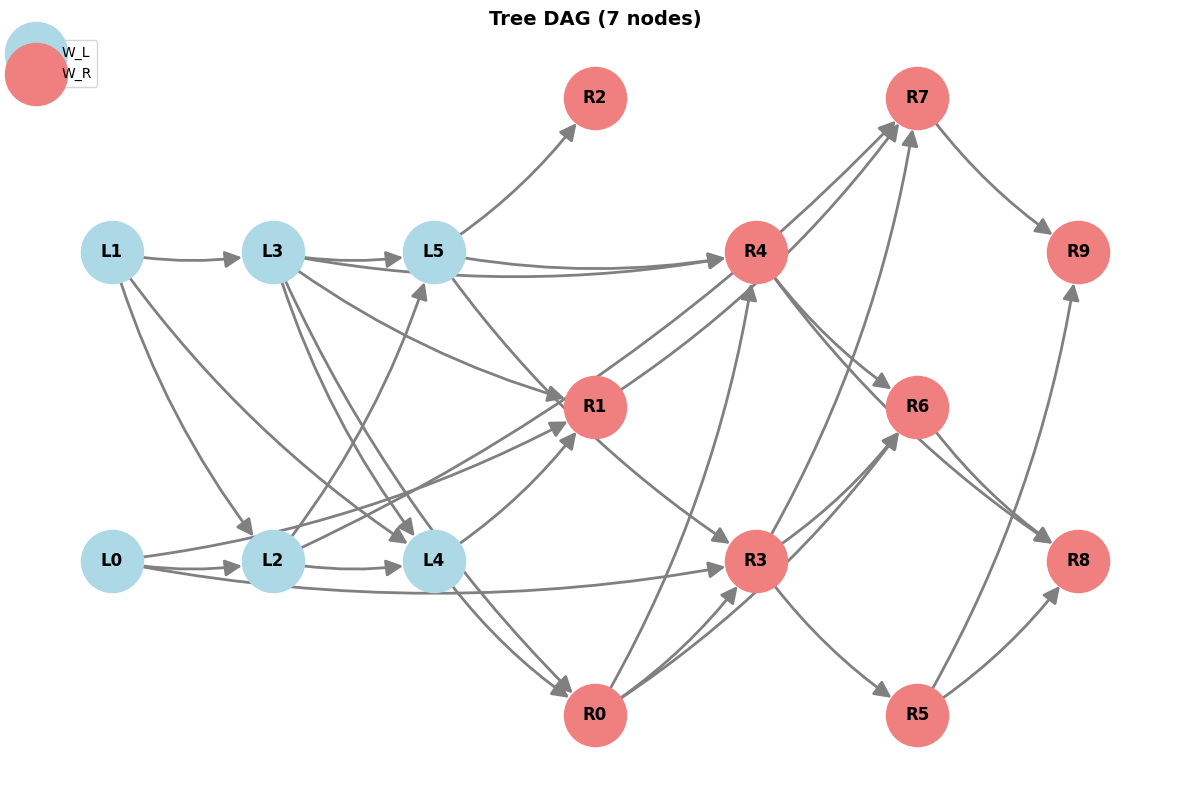

In [136]:
from symbolic_bounds.dag import DAG
%load_ext autoreload
%autoreload 2
from symbolic_bounds.test_constraints import validate_constraints


from symbolic_bounds.random_dag_generator import (
    generate_random_partitioned_dag, 
    generate_random_chain_dag,
    generate_random_tree_dag,
    print_dag_summary
)
import matplotlib.pyplot as plt



tree_dag = generate_random_partitioned_dag(n=16)
print_dag_summary(tree_dag)
fig3 = tree_dag.draw(figsize=(12, 8), title="Tree DAG (7 nodes)")
plt.show()

# validate_constraints(tree_dag, verbose=True)
